In [2]:
## Keras layers for LSTM RNN 

from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten
from keras import regularizers, optimizers
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pywt


Using TensorFlow backend.


In [5]:
## load data
print('Loading data...')

# X = np.genfromtxt('shuffledSet_w50_s10.txt')
# X1 = np.reshape(X,(8430,50,11))

# ## ========================   headers  ====================================================
# # Depth    ROP     WOB     RPM     Torque     Bit Size     GR     RHOB     NPHI     DT     RD
# ## ========================================================================================

X = np.genfromtxt('shuffledSet_w32_s4.txt')
X1 = np.reshape(X,(29504,32,10))

## ========================   headers  ====================================================
# Depth    ROP     WOB     RPM     Torque   Flow-in  MSE     GR     RHOB     NPHI          
## ========================================================================================


print('data loaded', '  We have', X1.shape[0], 'examples')



Loading data...
data loaded   We have 29504 examples


In [7]:
# split to test and train
X, Y = X1[:,:,0:7], X1[:,:,7:]

# split into train and test sets
x_train = X[:20000,:,[1, 2, 4, 5, 6]]
y_train = Y[:20000, :, 1]  # 0 for GR, 1 for RHOB

x_test = X[20001:25001,:,[1, 2, 4, 5, 6]]
y_test = Y[20001:25001, :, 1]


## sanity check
#x_train = X[0:1,:,:]
#y_train = Y[0:1, :, 1]  # 0 for GR, 1 for RHOB

#x_test = X[6744:,:,:]
#y_test = Y[6744:, :, 1]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(20000, 32, 5) (20000, 32) (5000, 32, 5) (5000, 32)


The data set is uploaded and sliced as follows, [samples, timesteps, features] = $[m, T_x, x]$

Then we implement our BiLSTM model.

The model has the following architecture. ==>   

In [8]:
## Wavelet transform for later
#x = np.asarray(x_train[0,:,1])
#y = np.asarray(y_train[0,:])
#print(x.shape)
#cA, cD, cB, cC = np.asarray(pywt.wavedec(x, 'haar', mode='constant', level=3))
#aA, aD, aB, aC = np.asarray(pywt.wavedec(y, 'haar', mode='constant', level=3))

#plt.plot(aD)
#plt.plot(cD)              

In [15]:
def StatefulLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test):
    
    # network
    input_dim = (x_train.shape[1],x_train.shape[2])
    
    new_model = Sequential()
    model = Sequential()
    for i in range(len(units)-1):
        #print((units[i]))
        model.add(LSTM(units[i], batch_input_shape = (batch_size, input_dim[0], input_dim[1]), 
                       kernel_regularizer=regularizers.l2(0.01), 
                       recurrent_regularizer=regularizers.l2(0.01), 
                       bias_regularizer=regularizers.l2(0.01), 
                       activation='tanh', 
                        stateful=True, return_sequences=True))
        
        new_model.add(LSTM(units[i], batch_input_shape = (1, input_dim[0], input_dim[1]), 
                       kernel_regularizer=regularizers.l2(0.01), 
                       recurrent_regularizer=regularizers.l2(0.01), 
                       bias_regularizer=regularizers.l2(0.01), 
                       activation='tanh', 
                        stateful=True, return_sequences=True))
        
        new_model.add(Dropout(dropout))
        model.add(Dropout(dropout))



    model.add(LSTM(units[len(units)-1], batch_input_shape = (batch_size, input_dim[0], input_dim[1]),
                   kernel_regularizer=regularizers.l2(0.01), 
                   recurrent_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01), 
                   activation='tanh', stateful=True))

    new_model.add(LSTM(units[len(units)-1], batch_input_shape = (1, input_dim[0], input_dim[1]),
                   kernel_regularizer=regularizers.l2(0.01), 
                   recurrent_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01), 
                   activation='tanh', stateful=True))

    
    
    model.add(Dropout(dropout))
    model.add((Dense(input_dim[0])))

    
    new_model.add(Dropout(dropout))
    new_model.add((Dense(input_dim[0])))

    # try using different optimizers and different optimizer configs
    opt = optimizers.Adam(lr = learning_rate)
    model.compile(loss = 'mae', optimizer = opt)
    new_model.compile(loss = 'mae', optimizer = opt)
    model.summary()
    
    for i in range(epochNo):
        print('epoch:',i+1)
        model.fit(x_train, y_train, epochs = 1, batch_size = batch_size, validation_data=(x_test, y_test), 
                  verbose=1, shuffle=False)
        model.reset_states()

    
    
    return model, new_model

In [16]:
def StatefulBiLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test):
    
    # network
    input_dim = (x_train.shape[1],x_train.shape[2])
    
    new_model = Sequential()
    model = Sequential()
    for i in range(len(units)-1):
        #print((units[i]))
        model.add(Bidirectional(LSTM(units[i], 
                       kernel_regularizer=regularizers.l2(0.01), 
                       recurrent_regularizer=regularizers.l2(0.01), 
                       bias_regularizer=regularizers.l2(0.01), 
                       activation='tanh', 
                        stateful=True, return_sequences=True), batch_input_shape = (batch_size, input_dim[0], input_dim[1])))
        
        
        
        
        new_model.add(Bidirectional(LSTM(units[i], 
                       kernel_regularizer=regularizers.l2(0.01), 
                       recurrent_regularizer=regularizers.l2(0.01), 
                       bias_regularizer=regularizers.l2(0.01), 
                       activation='tanh', 
                        stateful=True, return_sequences=True), batch_input_shape = (1, input_dim[0], input_dim[1])))
        
        new_model.add(Dropout(dropout))
        model.add(Dropout(dropout))



    model.add(Bidirectional(LSTM(units[len(units)-1],
                   kernel_regularizer=regularizers.l2(0.01), 
                   recurrent_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01), 
                   activation='tanh', stateful=True), batch_input_shape = (batch_size, input_dim[0], input_dim[1])))

    new_model.add(Bidirectional(LSTM(units[len(units)-1], 
                   kernel_regularizer=regularizers.l2(0.01), 
                   recurrent_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01), 
                   activation='tanh', stateful=True), batch_input_shape = (1, input_dim[0], input_dim[1])))

    
    
    model.add(Dropout(dropout))
    model.add((Dense(input_dim[0])))

    
    new_model.add(Dropout(dropout))
    new_model.add((Dense(input_dim[0])))

    # try using different optimizers and different optimizer configs
    opt = optimizers.Adam(lr = learning_rate)
    model.compile(loss = 'mae', optimizer = opt)
    new_model.compile(loss = 'mae', optimizer = opt)
    model.summary()
    
    
    for i in range(epochNo):
        print('epoch:',i+1)
        model.fit(x_train, y_train, epochs = 1, batch_size = batch_size, validation_data=(x_test, y_test), 
                  verbose=1, shuffle=False)
        model.reset_states()

    
    
    return model, new_model

In [17]:
def StatelessLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test):
    
    # network
    input_dim = (x_train.shape[1],x_train.shape[2])
    
    model = Sequential()
    for i in range(len(units)-1):
        model.add(LSTM(units[i], input_shape = (input_dim[0], input_dim[1]), 
                       kernel_regularizer=regularizers.l2(0.01), 
                       recurrent_regularizer=regularizers.l2(0.01), 
                       bias_regularizer=regularizers.l2(0.01), 
                       activation='tanh', return_sequences=True))
        
        
        model.add(Dropout(dropout))



    model.add(LSTM(units[len(units)-1], input_shape = (input_dim[0], input_dim[1]),
                   kernel_regularizer=regularizers.l2(0.01), 
                   recurrent_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01), 
                   activation='tanh'))


    
    
    model.add(Dropout(dropout))
    model.add((Dense(input_dim[0])))

    

    # try using different optimizers and different optimizer configs
    opt = optimizers.Adam(lr = learning_rate)
    model.compile(loss = 'mae', optimizer = opt)
    model.summary()

    Prediction = model.fit(x_train, y_train, epochs = epochNo, batch_size = batch_size, validation_data=(x_test, y_test),\
                        verbose=1, shuffle=False)

    
    return model, Prediction

In [18]:
def StatelessBiLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test):
    
    # network
    input_dim = (x_train.shape[1],x_train.shape[2])
    
    model = Sequential()
    for i in range(len(units)-1):
        model.add(Bidirectional(LSTM(units[i], 
                kernel_regularizer=regularizers.l2(0.01), 
                recurrent_regularizer=regularizers.l2(0.01), 
                bias_regularizer=regularizers.l2(0.01), 
                activation='tanh', return_sequences=True), input_shape = (input_dim[0], input_dim[1])))
        

        model.add(Dropout(dropout))



    model.add(Bidirectional(LSTM(units[len(units)-1],
                   kernel_regularizer=regularizers.l2(0.01), 
                   recurrent_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01), 
                   activation='tanh'), input_shape = (input_dim[0], input_dim[1])))


    
    
    model.add(Dropout(dropout))
    model.add((Dense(input_dim[0])))

    

    # try using different optimizers and different optimizer configs
    opt = optimizers.Adam(lr = learning_rate)
    model.compile(loss = 'mae', optimizer = opt)
    model.summary()
    
    Prediction = model.fit(x_train, y_train, epochs = epochNo, batch_size = batch_size, validation_data=(x_test, y_test),\
                        verbose=1, shuffle=False)

    
    return model, Prediction

In [19]:
# ## My network
# def StatelessLSTM(x_train):
#     input_dim = (x_train.shape[1],x_train.shape[2])
#     units = 25

#     model = Sequential()
#     #model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape = (x_train.shape[1],x_train.shape[2])))
#     #model.add(Bidirectional(LSTM(20, return_sequences=True))
#     model.add(LSTM(units, return_sequences=True, input_shape = (x_train.shape[1],x_train.shape[2]),
#              kernel_regularizer=regularizers.l2(0.01), 
#                    recurrent_regularizer=regularizers.l2(0.01), 
#                                 bias_regularizer=regularizers.l2(0.01)))
#     model.add(LSTM(units, return_sequences=True,kernel_regularizer=regularizers.l2(0.01), 
#                    recurrent_regularizer=regularizers.l2(0.01), 
#                                 bias_regularizer=regularizers.l2(0.01)))
#     model.add(LSTM(units, return_sequences=True,kernel_regularizer=regularizers.l2(0.01), 
#                    recurrent_regularizer=regularizers.l2(0.01), 
#                                 bias_regularizer=regularizers.l2(0.01)))
#     model.add(LSTM(units))

#     model.add((Dense(50)))

#     # try using different optimizers and different optimizer configs
#     model.compile(loss='mae', optimizer='adam')

#     model.summary()
#     return model

In [36]:
units = [6, 5]
dropout = 0
batch_size = 200
epochNo = 200
learning_rate = 0.01
WhichOne = 1


if WhichOne == 1 :
    model, Prediction = StatelessLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, \
                                      x_test, y_test)
elif WhichOne == 2:
        model, new_model = StatefulLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, \
                                        x_test, y_test)
elif WhichOne == 3:
        model, Prediction = StatelessBiLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, \
                                           x_test, y_test)
elif WhichOne == 4:
    model, new_model = StatefulBiLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test)

    
    

#model, new_model = StatefulBiLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test)

# model, new_model = StatefulLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test)

# model, Prediction = StatelessLSTM(x_train, y_train, batch_size, units, dropout, epochNo, learning_rate, x_test, y_test)

# Prediction = model.fit(x_train, y_train, epochs=120, batch_size=192, validation_data=(x_test, y_test),\
#                        verbose=1, shuffle=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32, 6)             288       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 6)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 5)                 240       
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                192       
Total params: 720
Trainable params: 720
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 11s 551us/step - loss: 0.7196 - val_

20000/20000 [==============================] - 6s 296us/step - loss: 0.5114 - val_loss: 0.4935
Epoch 68/200
20000/20000 [==============================] - 6s 292us/step - loss: 0.5082 - val_loss: 0.4936
Epoch 69/200
20000/20000 [==============================] - 6s 303us/step - loss: 0.5083 - val_loss: 0.4903
Epoch 70/200
20000/20000 [==============================] - 6s 293us/step - loss: 0.5081 - val_loss: 0.4926
Epoch 71/200
20000/20000 [==============================] - 6s 302us/step - loss: 0.5113 - val_loss: 0.4966
Epoch 72/200
20000/20000 [==============================] - 6s 304us/step - loss: 0.5119 - val_loss: 0.4960
Epoch 73/200
20000/20000 [==============================] - 6s 282us/step - loss: 0.5106 - val_loss: 0.4938
Epoch 74/200
20000/20000 [==============================] - 5s 271us/step - loss: 0.5113 - val_loss: 0.4903
Epoch 75/200
20000/20000 [==============================] - 5s 269us/step - loss: 0.5083 - val_loss: 0.4925
Epoch 76/200
20000/20000 [===============

KeyboardInterrupt: 

In [30]:
## transfer the statefull LSTM to a proper dimension model 
if WhichOne == 2 or WhichOne == 4 :
    opt = optimizers.Adam(lr = learning_rate)
    old_weights = model.get_weights()
    new_model.set_weights(old_weights)
    # compile model
    new_model.compile(loss = 'mae', optimizer = opt)



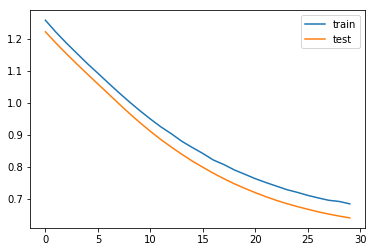

In [31]:
# plot history
Prediction = new_model
if WhichOne == 1 or WhichOne == 3 :
    plt.plot(Prediction.history['loss'], label='train')
    plt.plot(Prediction.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [24]:
# make prediction
yhat = model.predict(x_test)

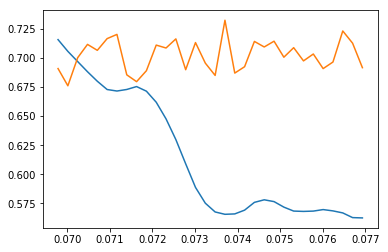

In [27]:
sample = 140
plt.plot(X[sample, :, 0], y_test[sample,:])
plt.plot(X[sample, :, 0], yhat[sample,:])